# Summary

This notebook explores an enhanced implementation of the VAD processing. The problem was that we were triggering audio recording too early due to false positives. This new implementation uses a sliding window approach (taken from the py-webrtcvad examples file) to reduce false positives thereby improving accuracy.

In [2]:
import collections
import time
from collections.abc import Iterable

import numpy as np
import sounddevice as sd
import webrtcvad
from scipy.signal import resample_poly

In [4]:
sd.query_devices()

> 0 MacBook Pro Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Pro Speakers, Core Audio (0 in, 2 out)
  2 Microsoft Teams Audio, Core Audio (2 in, 2 out)
  3 BlackHole/Speakers, Core Audio (0 in, 2 out)

In [13]:
class Frame:
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

    def __repr__(self):
        return f"Frame(timestamp={self.timestamp}, duration={self.duration}, bytes_length={len(self.bytes)})"


def audio_frame_generator(
    *,
    frame_duration_ms: int,
    sample_rate: int,
    device: int,
) -> Iterable[Frame]:
    """
    Generate audio frames from the microphone.
    """
    duration = frame_duration_ms / 1000.0  # E.g., 0.03 seconds
    frame_size = int(sample_rate * duration)  # E.g., 44100 * 0.03 = 1323 samples
    timestamp = 0.0
    with sd.InputStream(
        samplerate=sample_rate,
        channels=1,
        dtype="int16",
        blocksize=frame_size,
        device=device,
    ) as stream:
        while True:
            audio = stream.read(frame_size)[0]
            yield Frame(audio.tobytes(), timestamp, duration)
            timestamp += duration


def resample(
    audio: np.ndarray, original_sample_rate: int, target_sample_rate: int
) -> np.ndarray:
    """
    This is the equivalent of calling:
    resample_poly(audio, target_sample_rate, original_sample_rate)

    But the program will use less compute resources if we reduce the
    ratio 44100:16000 to 441:160 with np.gcd (Greatest Common Divisor)
    which finds the largest integer that evenly divides two numbers.
    """
    gcd = np.gcd(original_sample_rate, target_sample_rate)
    return resample_poly(audio, target_sample_rate // gcd, original_sample_rate // gcd)


def resample_frames(
    frames: Iterable[Frame],
    *,
    original_sample_rate: int,
    target_sample_rate: int,
) -> Iterable[Frame]:
    """
    A generator that wraps an audio frame generator and resamples
    the audio frames.
    """
    for frame in frames:
        audio = np.frombuffer(frame.bytes, dtype=np.int16)
        resampled_audio = resample(audio, original_sample_rate, target_sample_rate)
        # We are changing the sample rate, not the bit-depth.
        # Therefore we can keep the same dtype.
        resampled_audio = np.clip(resampled_audio, -32768, 32767).astype(np.int16)
        yield Frame(resampled_audio.tobytes(), frame.timestamp, frame.duration)


def vad_collector(
    *,
    sample_rate: int,
    frame_duration_ms: int,
    padding_duration_ms: int,
    vad: webrtcvad.Vad,
    frames: Iterable[Frame],
    silence_timeout: float = 2.0,  # Optional: silence timeout in seconds
) -> Iterable[bytes]:
    """
    Implementation taken from the example in the py-webrtcvad
    https://github.com/wiseman/py-webrtcvad/blob/master/example.py

    Altered to including a silence timeout feature.
    """
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    # We use a deque for our sliding window/ring buffer.
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    # We have two states: TRIGGERED and NOTTRIGGERED. We start in the
    # NOTTRIGGERED state.
    triggered = False
    silence_start = None

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        print("1" if is_speech else "0", triggered)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            # If we're NOTTRIGGERED and more than 90% of the frames in
            # the ring buffer are voiced frames, then enter the
            # TRIGGERED state.
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                # When we enter the TRIGGERED state, we want to start the silence timer.
                silence_start = None
                print("+(%s)" % (ring_buffer[0][0].timestamp,))
                # We want to yield all the audio we see from now until
                # we are NOTTRIGGERED, but we have to start with the
                # audio that's already in the ring buffer.
                for f, s in ring_buffer:
                    voiced_frames.append(f)
                ring_buffer.clear()
            # While we're in the NONTRIGGERED state, we want to check for silence timeout.
            elif silence_start and time.time() - silence_start > silence_timeout:
                print("Silence timeout. Stop recording.")
                break
        else:
            # We're in the TRIGGERED state, so collect the audio data
            # and add it to the ring buffer.
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            # If more than 90% of the frames in the ring buffer are
            # unvoiced, then enter NOTTRIGGERED and yield whatever
            # audio we've collected.
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                print("-(%s)" % frame)
                triggered = False
                yield b"".join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
                # When we enter the NOTTRIGGERED state, we want to start the silence timer.
                if silence_start is None:
                    print("Silence detected, starting silence timer.")
                    silence_start = time.time()
            else:
                # If we're still in the TRIGGERED state, reset the
                # silence start time.
                print("Continuing in TRIGGERED state.")
                silence_start = None
    if triggered:
        print("-(%s)" % frame)
    print("\n")
    # If we have any leftover voiced audio when we run out of input,
    # yield it.
    if voiced_frames:
        yield b"".join([f.bytes for f in voiced_frames])


frame_duration_ms = 30  # Duration of each frame in milliseconds
mic_sample_rate = 44100  # Original sample rate
vad_sample_rate = 32000  # Sample rate for VAD processing
device = 0  # Device index for the microphone (change as needed)

raw_frame_generator = audio_frame_generator(
    frame_duration_ms=frame_duration_ms,
    sample_rate=mic_sample_rate,
    device=device,
)

resampled_frames = resample_frames(
    raw_frame_generator,
    original_sample_rate=mic_sample_rate,
    target_sample_rate=vad_sample_rate,
)

vad = webrtcvad.Vad(3)
voiced_audio_generator = vad_collector(
    sample_rate=vad_sample_rate,
    frame_duration_ms=frame_duration_ms,
    padding_duration_ms=300,
    vad=vad,
    frames=resampled_frames,
    silence_timeout=2.0,
)

a = []
for i, voiced_audio in enumerate(voiced_audio_generator):
    print(f"Voiced audio chunk {i + 1} of length {len(voiced_audio)} bytes detected.")
    a.append(voiced_audio)

0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
0 False
1 False
1 False
1 False
1 False
1 False
1 False
1 False
1 False
1 False
1 False
+(0.7200000000000004)
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
1 True
Continuing in TRIGGERED state.
0 True
Continuing in TRIGGERED state.
0 True
Continuing in T

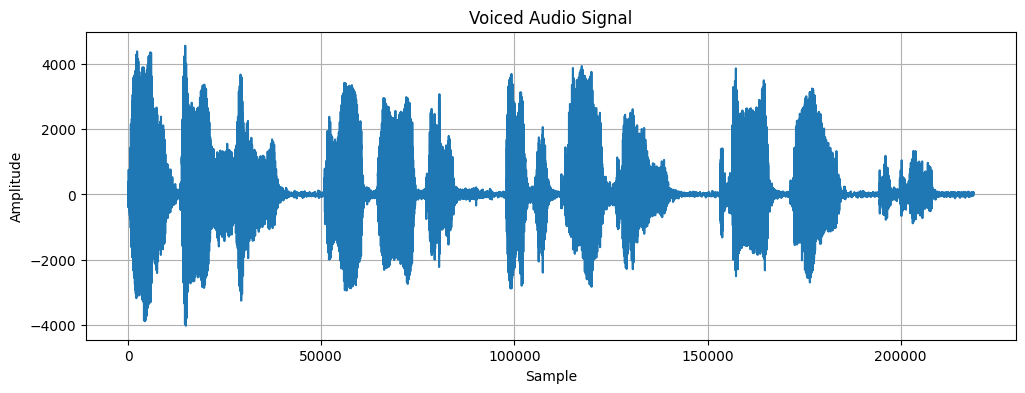

In [24]:
import matplotlib.pyplot as plt

audio_data = np.frombuffer(b"".join(a), dtype=np.int16)

plt.figure(figsize=(12, 4))
plt.plot(audio_data)
plt.title("Voiced Audio Signal")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()